# Classification supervisée d'images via CNN Transfer Learning

L'apprentissage par transfert est le phénomène par lequel un nouvel apprentissage est facilité grâce à des apprentissages antérieurs similaires.


L'augmentation des données est une technique utilisée pour augmenter la quantité de données d'entraînement en créant de nouveaux exemples à partir de ceux existants. Cette technique peut contribuer à améliorer la précision des CNN en réduisant le surapprentissage. Le surajustement se produit lorsque le modèle mémorise les données d'entraînement et ne parvient pas à généraliser aux données invisibles.
Il existe plusieurs façons d'augmenter les données, notamment le retournement, la rotation, le recadrage et l'ajout de bruit aux images. En appliquant ces transformations aux images, nous pouvons créer de nouveaux exemples similaires aux originaux mais différant par certains aspects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import shutil
import random
import time
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import plot_keras_history
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 100

In [2]:
df_0 = pd.read_csv("df.csv", index_col = 0 )

In [3]:
df_0.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,product_rating,overall_rating,brand,product_specifications,description cleaned,product name cleaned,description cleaned DL,product name cleaned DL,product_category,label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value...",key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicol...,elegance polyester multicolor abstract eyelet door curtain,key of elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor ab...,elegance polyester multicolor abstract eyelet door curtain,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val...",specification cotton bath towel bath towel red yellow blue bath towel feature machine washable y...,cotton bath towel,of cotton bath towel bath towel red yellow blue bath towel machine washable yes material cotton ...,cotton bath towel,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""valu...",key feature cotton terry face towel set size small height inch cotton terry face towel set piece...,cotton terry face towel set,key of cotton terry face towel set size small height inch cotton terry face towel set piece face...,cotton terry face towel set,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine ...",key feature royal fashion cotton printed king sized double royal wedding royal fashion cotton pr...,royal fashion cotton printed king sized double,key of royal fashion cotton printed king sized double royal for wedding of royal fashion cotton ...,royal fashion cotton printed king sized double,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...

In [4]:
df = df_0[['image','product_category']]
df.head()

,image,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [5]:
#on encode le la catégorie de produit
le = LabelEncoder()
le.fit(df["product_category"])
df["label"] = le.transform(df["product_category"])

/var/folders/4c/q7brdcr51gv3dycr8qx1xz_40000gn/T/ipykernel_91735/919681911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = le.transform(df["product_category"])


In [6]:
df.groupby("label").count()

,image,product_category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [7]:
df.head()

,image,product_category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [66]:
# On crée un dataframe pour ajouter les scores au fur et à mesure
scores = pd.DataFrame(columns = ['Modèle', 'Validation Accuracy', 'Test Accuracy', 'Validation Loss','Test Loss',"Temps nécessaire pour l'entrainement du modèle" ])

## Création du modèle de classification

In [9]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [10]:
#fonction de preparation des images
def image_prep_fct(df) :
    path = 'Flipkart 2/Images/'
    prepared_images = []
    list_photos = df['image'].tolist()
    for image in list_photos :
        img = load_img(path + image ,target_size=(224, 224))
        # convert the image pixels to a numpy array
        img = img_to_array(img)
        # reshape data for the model
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        # prepare the image for the VGG model
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
        
    return prepared_images_np

In [11]:
#on crée un dataframe de test et de train
df_train, df_test = train_test_split(df, test_size=0.2)

In [12]:
#on applique la fonction aux dataframes train et test
images_np_train = image_prep_fct(df_train)
print(images_np_train.shape)

images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)

/Users/juliesaubot/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [13]:
# on crée les variables X et Y
X = images_np_train
#on transforme le label en matrice de la même taille que X
y = to_categorical(df_train['label'])

#on crée les variables X_test et y_test
X_test = images_np_test
#on transforme le label en matrice de la même taille que X
y_test = to_categorical(df_test['label'])

In [14]:
# on separe ensuite pour avoir un dataset de validation
#le parametre stratify permet de garder les mêmes proportions d'observations dans chaque classe dans les essembles de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=123)
X_train.shape

(630, 224, 224, 3)

In [15]:
# Création du modèle 
model1 = create_model_fct()

# Création du callback
model1_save_path = "./model1_best_weights.h5"
# Callback pour sauvegarder le modèle ou des poids à un certain intervalle, afin que le modèle ou les poids puissent être chargés plus tard pour continuer l'entraînement à partir de l'état enregistré
checkpoint = ModelCheckpoint(model1_save_path, # path to save the model file
                             monitor='val_loss', # The metric name to monitor
                             verbose=1, # Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
                             save_best_only=True, #if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten
                             mode='min') # If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity

# EarlyStopping previent l'overfitting et economise du temps d'entrainement en stoppant l'entrainement lorsqu'une condition n'est plus validé
# ici, le but est de minimiser la perte donc l'entrainement va s'arrêter quand la perte arrête de diminuer pendant 5 epochs de suite
es = EarlyStopping(monitor='val_loss', # Quantity to be monitored
                   mode='min', #  In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
                   verbose=1, # Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
                   patience=5) # Number of epochs with no improvement after which training will be stopped.

callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
# Entraîner sur les données d'entraînement (X_train, y_train)
start = time.time()
history1 = model1.fit(X_train, 
                      y_train,
                      epochs=20,
                      batch_size=64, 
                      callbacks=callbacks_list, 
                      validation_data=(X_val, y_val),
                      verbose=1)
end = time.time()
elapsed1 = end - start

print(f'Temps d\'exécution : {elapsed1:.2}ms')

Epoch 1/50


2023-10-08 13:32:08.207406: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - ETA: 0s - loss: 6.0662 - accuracy: 0.4143
Epoch 1: val_loss improved from inf to 1.59237, saving model to ./model1_best_weights.h5
10/10 [==============================] - 50s 5s/step - loss: 6.0662 - accuracy: 0.4143 - val_loss: 1.5924 - val_accuracy: 0.7571
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.9083 - accuracy: 0.6683
Epoch 2: val_loss improved from 1.59237 to 1.40772, saving model to ./model1_best_weights.h5
10/10 [==============================] - 50s 5s/step - loss: 1.9083 - accuracy: 0.6683 - val_loss: 1.4077 - val_accuracy: 0.7857
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.4666 - accuracy: 0.7143
Epoch 3: val_loss improved from 1.40772 to 1.34251, saving model to ./model1_best_weights.h5
10/10 [==============================] - 49s 5s/step - loss: 1.4666 - accuracy: 0.7143 - val_loss: 1.3425 - val_accuracy: 0.8286
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss:

In [17]:
checkpoint.best

1.1515326499938965

In [18]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 70s 4s/step - loss: 0.0141 - accuracy: 0.9952
Training Accuracy: 0.9952

7/7 [==============================] - 24s 3s/step - loss: 1.2191 - accuracy: 0.8524
Validation Accuracy:  0.8524


In [19]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path)

loss_val_1, accuracy_val_1 = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_1))

loss_test_1, accuracy_test_1 = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_1))


Validation Accuracy :  0.8238
Test Accuracy       :  0.8286


In [20]:
#reformatage du temps d'entrainement

time1 = time.strftime("%H:%M:%S", time.gmtime(elapsed1))

In [67]:
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Approche préparation initiale des images',
                                          'Validation Accuracy': accuracy_val_1,
                                          'Test Accuracy':accuracy_test_1,
                                          'Validation Loss':loss_val_1,
                                          'Test Loss':loss_test_1,
                                         "Temps nécessaire pour l'entrainement du modèle":time1},
                                         index = [0])]).reset_index(drop=True)

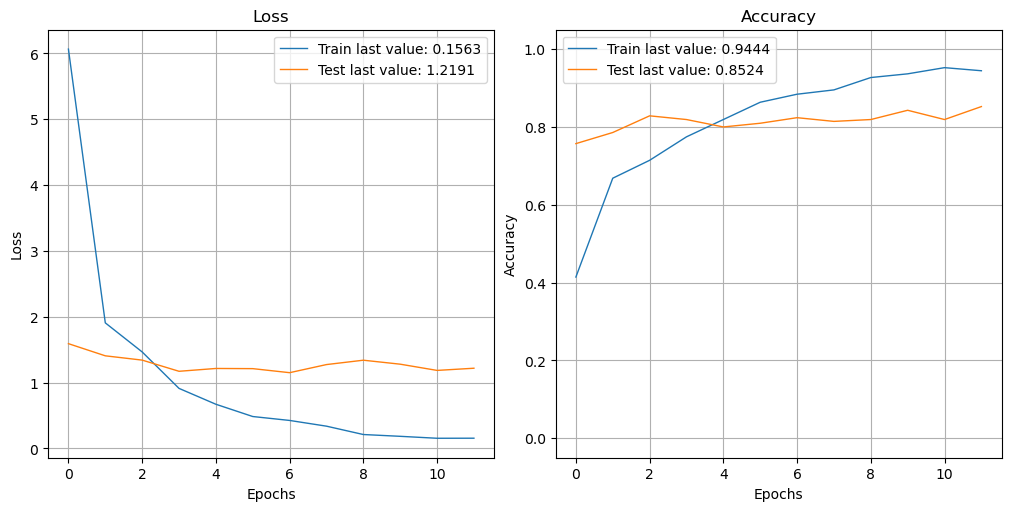

In [22]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [23]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 24s 3s/step
[3 1 6 5 1 4 6 0 6 1 5 2 1 3 2 2 2 1 4 3 1 3 0 2 2 2 5 0 1 3 1 6 5 4 5 4 0
 6 0 5 0 4 1 1 0 6 5 3 1 4 3 1 0 6 0 2 5 3 4 1 5 4 5 3 6 0 1 3 3 1 0 2 0 5
 3 1 2 6 4 5 6 0 1 5 1 5 5 4 0 2 6 6 2 2 6 3 5 4 5 2 6 5 2 4 4 3 1 0 0 2 6
 1 6 0 6 6 1 6 2 5 4 4 6 1 3 3 2 4 0 3 0 3 0 0 1 4 3 1 6 4 4 3 5 5 0 5 2 0
 5 1 3 3 6 3 4 1 2 4 4 3 1 5 5 5 3 6 4 3 3 1 0 2 5 6 0 2 6 1 6 5 4 4 4 0 4
 2 6 2 4 2 3 1 4 0 5 6 6 2 1 5 3 0 2 2 2 6 0 3 2 2]

[3 1 6 5 1 0 6 4 6 1 5 2 1 3 3 2 2 1 0 3 1 3 0 4 2 2 5 0 1 5 1 6 5 4 5 4 0
 6 0 2 0 4 1 1 0 6 5 3 1 0 1 1 4 6 1 2 5 3 4 1 4 4 5 3 6 0 1 3 3 1 0 2 0 5
 3 1 2 6 0 5 6 0 3 5 1 5 5 4 1 2 6 6 2 2 6 3 5 0 5 2 6 5 2 0 4 3 1 4 0 2 6
 1 6 0 6 6 3 6 2 1 4 4 6 3 5 4 2 4 0 4 0 2 4 0 1 4 3 1 6 4 4 4 5 5 0 5 2 0
 5 1 3 0 6 3 4 1 2 4 4 3 0 5 5 5 3 6 4 3 0 1 0 1 5 6 0 2 6 1 6 5 0 4 4 3 0
 0 6 2 4 2 3 1 4 0 5 6 6 2 1 5 3 0 2 2 3 6 0 3 0 2]


In [24]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[22  2  0  1  4  0  0]
 [ 1 27  0  3  0  0  0]
 [ 2  1 25  2  1  0  0]
 [ 2  1  1 21  3  2  0]
 [ 8  0  0  0 21  0  0]
 [ 0  1  1  0  1 27  0]
 [ 0  0  0  0  0  0 30]]


In [25]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [26]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[22  2  0  1  4  0  0]
 [ 1 27  0  3  0  0  0]
 [ 2  1 25  2  1  0  0]
 [ 2  1  1 21  3  2  0]
 [ 8  0  0  0 21  0  0]
 [ 0  1  1  0  1 27  0]
 [ 0  0  0  0  0  0 30]]

              precision    recall  f1-score   support

           0       0.63      0.76      0.69        29
           1       0.84      0.87      0.86        31
           2       0.93      0.81      0.86        31
           3       0.78      0.70      0.74        30
           4       0.70      0.72      0.71        29
           5       0.93      0.90      0.92        30
           6       1.00      1.00      1.00        30

    accuracy                           0.82       210
   macro avg       0.83      0.82      0.82       210
weighted avg       0.83      0.82      0.83       210



<Axes: >

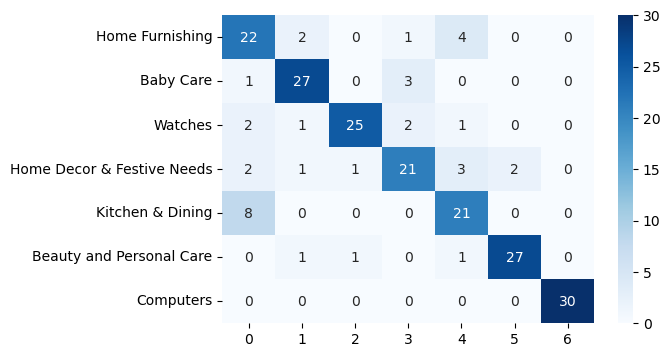

In [27]:
# on crée une liste des catégories
list_labels = df.product_category.unique().tolist()
list_labels

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [28]:
# Pour mélanger les images, classées initalement par classe
data = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [29]:
batch_size = 32
path = 'Flipkart 2/Images/'
def data_flow_fct(data, datagen, data_type=None) :
    #Takes the dataframe and the path to a directory + generates batches.The generated batches contain augmented/normalized data.
    data_flow = datagen.flow_from_dataframe(data, 
                                            directory=path, #path to the directory to read images from
                                            x_col='image', #column in dataframe that contains the filenames
                                            y_col='product_category', #column/s in dataframe that has the target data
                                            weight_col=None, #string, column in dataframe that contains the sample weights.
                                            target_size=(256, 256), #tuple of integers (height, width), default: (256,256). The dimensions to which all images found will be resized.
                                            classes=None, #optional list of classes
                                            class_mode='categorical', #Mode for yielding the targets. "categorical": 2D numpy array of one-hot encoded labels. Supports multi-label output.
                                            batch_size=batch_size,
                                            shuffle=True, #whether to shuffle the data (default: True)
                                            seed=42, #optional random seed for shuffling and transformations.
                                            subset=data_type #Subset of data ("training" or "validation") if validation_split is set in ImageDataGenerator
                                           )
    return data_flow

In [30]:
datagen_train = ImageDataGenerator(#    featurewise_center=True,
    #    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,
                                  preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [31]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
import time
start = time.time()

history2 = model2.fit(train_flow,
                      validation_data=val_flow,
                          # batch_size=batch_size, #ignored because the date is a generator 
                      epochs=20,
                      callbacks=callbacks_list,
                      verbose=1)
end = time.time()
elapsed2 = end - start

print(f'Temps d\'exécution : {elapsed2:.2}ms')

Epoch 1/50
 9/20 [============>.................] - ETA: 50s - loss: 6.6241 - accuracy: 0.3125

/Users/juliesaubot/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 4.4506 - accuracy: 0.4508
Epoch 1: val_loss improved from inf to 1.12381, saving model to ./model2_best_weights.h5
20/20 [==============================] - 126s 6s/step - loss: 4.4506 - accuracy: 0.4508 - val_loss: 1.1238 - val_accuracy: 0.6952
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.7536 - accuracy: 0.6286
Epoch 2: val_loss improved from 1.12381 to 0.95087, saving model to ./model2_best_weights.h5
20/20 [==============================] - 128s 6s/step - loss: 1.7536 - accuracy: 0.6286 - val_loss: 0.9509 - val_accuracy: 0.7381
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.7143
Epoch 3: val_loss improved from 0.95087 to 0.85407, saving model to ./model2_best_weights.h5
20/20 [==============================] - 117s 6s/step - loss: 1.2522 - accuracy: 0.7143 - val_loss: 0.8541 - val_accuracy: 0.7762
Epoch 4/50
20/20 [==============================] - ETA: 0s - lo

In [33]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 93s 5s/step - loss: 0.1323 - accuracy: 0.9556
Training Accuracy   : 0.9556

7/7 [==============================] - 32s 5s/step - loss: 0.8006 - accuracy: 0.7857
Validation Accuracy :  0.7857


In [34]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss_val_2, accuracy_val_2 = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_2))

loss_test_2, accuracy_test_2 = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_2))

Validation Accuracy :  0.7571
Test Accuracy       :  0.7571


In [35]:
#reformatage du temps d'entrainement

time2 = time.strftime("%H:%M:%S", time.gmtime(elapsed2))

In [68]:
scores = pd.concat([scores, pd.DataFrame({'Modèle':' Approche ImageDatagenerator avec data augmentation',
                                          'Validation Accuracy': accuracy_val_2,
                                          'Test Accuracy':accuracy_test_2,
                                          'Validation Loss':loss_val_2,
                                          'Test Loss':loss_test_2,
                                         "Temps nécessaire pour l'entrainement du modèle":time2
                                         }, index = [0])]).reset_index(drop=True)


In [72]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Approche préparation initiale des images,0.823810,0.828571,1.151533,0.780986,00:11:54
1,Approche ImageDatagenerator avec data augmentation,0.757143,0.757143,0.802688,1.108676,00:15:00
2,Approche nouvelle par Dataset sans data augmentation,0.797814,0.787302,0.982012,1.254702,00:18:03
3,Approche nouvelle par Dataset avec data augmentation intégrée au modèle,0.797814,0.765079,0.628237,0.680146,00:29:56


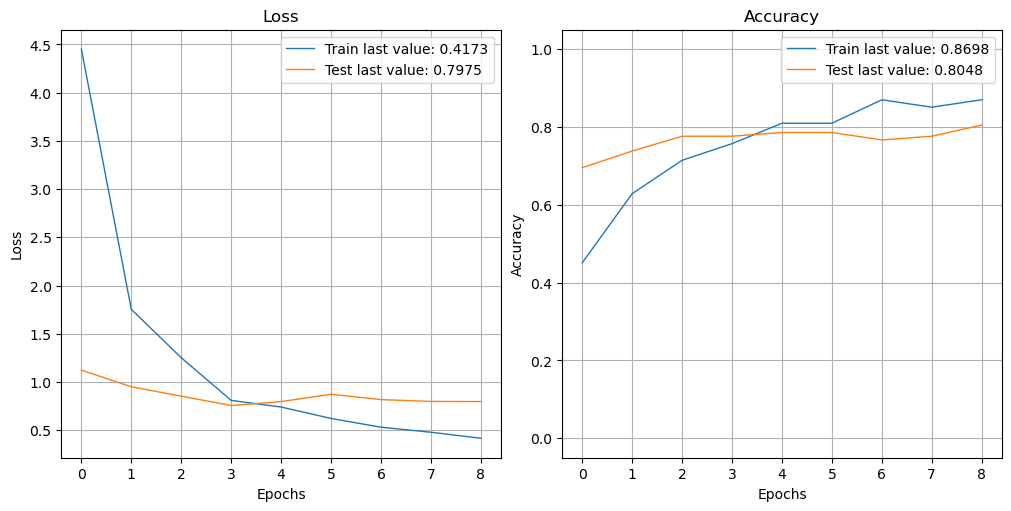

In [37]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

### Creation de sous dossiers pour les images 

In [38]:
# on crée une liste avec toutes les photos presentes 
list_photos = df['image'].tolist()
list_photos

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 '64d5d4a258243731dc7bbb1eef49ad74.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg',
 '893aa5ed55f7cff2eccea7758d7a86bd.jpg',
 'f355cc1ccb08bd0d283ed979b7ee7515.jpg',
 'dd0e3470a7e6ed76fd69c2da27721041.jpg',
 '41384da51732c0b4df3de8f395714fbb.jpg',
 '710ed5f2393a4b9e8823aa0029f71f93.jpg',
 '920154acbe49d3202ed7d2ed2df1ea13.jpg',
 '08452abdadb3db1e686b94a9c52fc7b6.jpg',
 '1e8741b5ae27a513546c94b3f3312aee.jpg',
 '189fa66a5fa6f08d2802a62ecf0be298.jpg',
 'bbb8cdc5406ff60ff06ff64630f2ca47.jpg',
 '1120bc768623572513df956172ffefeb.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '733aa1e801a139fa8dc7be9f0eff5ee0.jpg',
 '62c35de4df27437d3597963fac55a8b6.jpg',
 '33d97d63c037078cd3f08033966d6a88.jpg',
 'd7ca2b06b4f4d3b98c61c377b18a2d6b.jpg',
 'f74476ba64365d97a5be7d375cbf4c7a.jpg',
 'fda50982a672ef8835de5c1cc86f8bfc.jpg',
 '4788f5466992da09024b8ffcc8a5cba4.jpg',
 '653826cd53f1d9

In [39]:
#on va creer des un dossier pour test et un pour train
def create_folders():
    #on defini la taille du dataset train
    train_size = df.shape[0]* 0.70
    train_size
    path = 'Flipkart/Images/'
    train_folder = os.path.join(path, 'df_train')
    test_folder = os.path.join(path, 'df_test')
    #on melange la liste
    random.shuffle(list_photos)
    #on crée les dossiers train et test
    for folder in [train_folder, test_folder]:
        os.makedirs(folder)
    #on deplace les images dans les differents dossiers
    for index, value in enumerate(list_photos): 
        get_image = os.path.join('Flipkart/Images/', value) # Path to Images 
        if index < train_size:
            dest_folder = train_folder
        else:
            dest_folder = test_folder
        shutil.move(get_image, dest_folder) #shutil.move(src, dst, copy_function=copy2) :Recursively move a file or directory (src) to another location (dst) and return the destination.

In [40]:
#create_folders()

In [41]:
# on crée une liste des catégories
list_labels = df.product_category.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [42]:
#on va créer des sous-dossier de classes pour les images
def create_subfolders():
    for folder in ['df_test', 'df_train']:
        for label in list_labels:
            dest_0 = os.path.join('./Flipkart/Images',folder)
            dest = os.path.join(dest_0 ,label)
            os.makedirs(dest)
        path_img = os.path.join('Flipkart/Images/',folder)
        list_images = os.listdir(path_img)
        #on va deplacer les images dans des sous dossiers de leur catégories
        for name in list_images:
            if name.endswith('.jpg'):
                path = os.path.join('Flipkart/Images/', folder)
                get_image = os.path.join(path, name) # Path to Images
                cat = df.loc[df['image'] == name,'product_category'].values[0]
                dest = os.path.join(path,cat)
                shutil.move(get_image, dest) #shutil.move(src, dst) :Recursively move a file or directory (src) to another location (dst) and return the destination.

In [43]:
#create_subfolders()

### Creation des datasets de train, test et validation

In [44]:
batch_size = 32
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'

def dataset_fct(path, validation_split=0, data_type=None) :
    #return a tf.data.Dataset that yields batches of images from the subdirectories per classes, together with labels 0 to 6
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred',
                                                          label_mode='categorical',
                                                          class_names=None,
                                                          batch_size=batch_size, 
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split,
                                                          subset=data_type
                                                         )
    return dataset

In [45]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


In [46]:
# Création du modèle
model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
import time
start = time.time()
history3 = model3.fit(dataset_train,
                          validation_data=dataset_val,
                          #batch_size=batch_size, #ignored because the date is a generator
                          epochs=20,
                          callbacks=callbacks_list,
                          verbose=1)
end = time.time()
elapsed3 = end - start

print(f'Temps d\'exécution : {elapsed3:.2}ms')

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 7.0415 - accuracy: 0.4348
Epoch 1: val_loss improved from inf to 1.83726, saving model to ./model3_best_weights.h5
18/18 [==============================] - 85s 5s/step - loss: 7.0415 - accuracy: 0.4348 - val_loss: 1.8373 - val_accuracy: 0.7322
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 2.2377 - accuracy: 0.6721
Epoch 2: val_loss improved from 1.83726 to 1.53362, saving model to ./model3_best_weights.h5
18/18 [==============================] - 85s 5s/step - loss: 2.2377 - accuracy: 0.6721 - val_loss: 1.5336 - val_accuracy: 0.7158
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.7844
Epoch 3: val_loss improved from 1.53362 to 1.17157, saving model to ./model3_best_weights.h5
18/18 [==============================] - 86s 5s/step - loss: 1.1565 - accuracy: 0.7844 - val_loss: 1.1716 - val_accuracy: 0.7760
Epoch 4/50
18/18 [==============================] - ETA:

In [48]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 65s 3s/step - loss: 0.0029 - accuracy: 1.0000
Training Accuracy   : 1.0000

6/6 [==============================] - 22s 3s/step - loss: 1.1287 - accuracy: 0.8087
Validation Accuracy :  0.8087


In [49]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss_val_3, accuracy_val_3 = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_3))

loss_test_3, accuracy_test_3 = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_3))


Validation Accuracy :  0.7978
Test Accuracy       :  0.7873


In [50]:
#reformatage du temps d'entrainement

time3 = time.strftime("%H:%M:%S", time.gmtime(elapsed3))

In [69]:
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Approche nouvelle par Dataset sans data augmentation',
                                          'Validation Accuracy': accuracy_val_3,
                                          'Test Accuracy':accuracy_test_3,
                                          'Validation Loss':loss_val_3,
                                          'Test Loss':loss_test_3,
                                         "Temps nécessaire pour l'entrainement du modèle":time3
                                         }, index = [0])]).reset_index(drop=True)


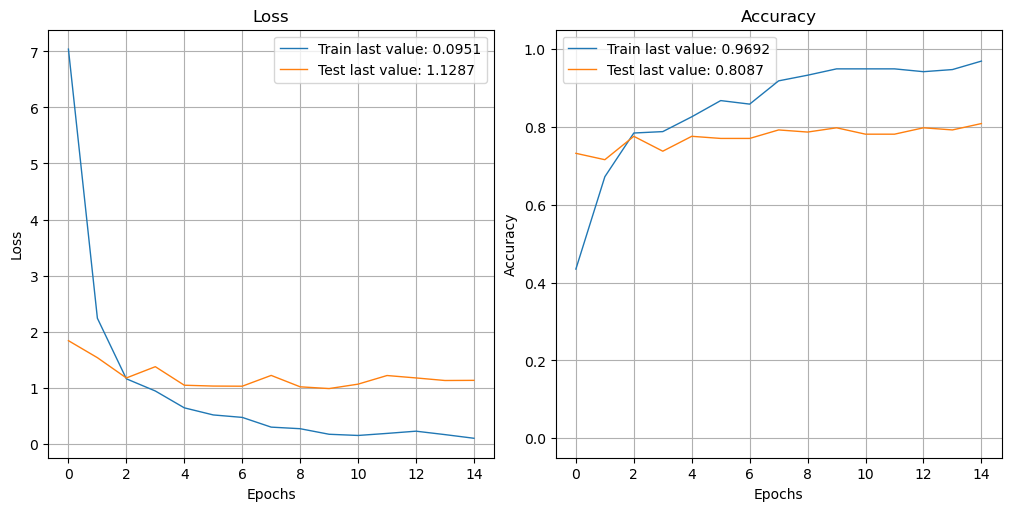

In [52]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [53]:
batch_size = 32
# On utilise les images qui sont classés dans des dossiers des differents catégories de produits
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred', 
                                                          label_mode='categorical',
                                                          class_names=None, 
                                                          batch_size=batch_size, 
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split, 
                                                          subset=data_type)
    return dataset

In [54]:
# on crée les datasets d'entrainement, de validation et de test
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


In [55]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [56]:
#fonction qui crée le modele de classification

def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    #On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [57]:
# Création du modèle
model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [58]:
start = time.time()
history4 = model4.fit(dataset_train,
                      validation_data=dataset_val,
                      #batch_size=batch_size, #ignored because the date is a generator
                      epochs=50, 
                      callbacks=callbacks_list, 
                      verbose=1)
end = time.time()
elapsed4 = end - start

print(f'Temps d\'exécution : {elapsed4:.2}ms')

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.9003 - accuracy: 0.2264
Epoch 1: val_loss improved from inf to 1.52566, saving model to ./model4_best_weights.h5
18/18 [==============================] - 89s 5s/step - loss: 1.9003 - accuracy: 0.2264 - val_loss: 1.5257 - val_accuracy: 0.5137
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.5169 - accuracy: 0.4710
Epoch 2: val_loss improved from 1.52566 to 1.21684, saving model to ./model4_best_weights.h5
18/18 [==============================] - 88s 5s/step - loss: 1.5169 - accuracy: 0.4710 - val_loss: 1.2168 - val_accuracy: 0.6448
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.6051
Epoch 3: val_loss improved from 1.21684 to 1.01405, saving model to ./model4_best_weights.h5
18/18 [==============================] - 88s 5s/step - loss: 1.2354 - accuracy: 0.6051 - val_loss: 1.0140 - val_accuracy: 0.7486
Epoch 4/50
18/18 [==============================] - ETA:

18/18 [==============================] - 88s 5s/step - loss: 0.5637 - accuracy: 0.8170 - val_loss: 0.6282 - val_accuracy: 0.7978
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.8170
Epoch 20: val_loss did not improve from 0.62824
18/18 [==============================] - 87s 5s/step - loss: 0.5525 - accuracy: 0.8170 - val_loss: 0.6596 - val_accuracy: 0.7869
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8442
Epoch 21: val_loss did not improve from 0.62824
18/18 [==============================] - 85s 5s/step - loss: 0.5294 - accuracy: 0.8442 - val_loss: 0.6290 - val_accuracy: 0.7814
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.8460
Epoch 22: val_loss did not improve from 0.62824
18/18 [==============================] - 87s 5s/step - loss: 0.4953 - accuracy: 0.8460 - val_loss: 0.6423 - val_accuracy: 0.7869
Epoch 23/50
18/18 [==============================] - ET

In [59]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 67s 4s/step - loss: 0.3559 - accuracy: 0.8931
Training Accuracy   : 0.8931

6/6 [==============================] - 23s 4s/step - loss: 0.6403 - accuracy: 0.8033
Validation Accuracy :  0.8033


In [60]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss_val_4, accuracy_val_4 = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_4))

loss_test_4, accuracy_test_4 = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_4))

Validation Accuracy :  0.7978
Test Accuracy       :  0.7651


In [61]:
#reformatage du temps d'entrainement

time4 = time.strftime("%H:%M:%S", time.gmtime(elapsed4))

In [70]:
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Approche nouvelle par Dataset avec data augmentation intégrée au modèle',
                                          'Validation Accuracy': accuracy_val_4,
                                          'Test Accuracy':accuracy_test_4,
                                          'Validation Loss':loss_val_4,
                                          'Test Loss':loss_test_4,
                                         "Temps nécessaire pour l'entrainement du modèle":time4
                                         }, index = [0])]).reset_index(drop=True)


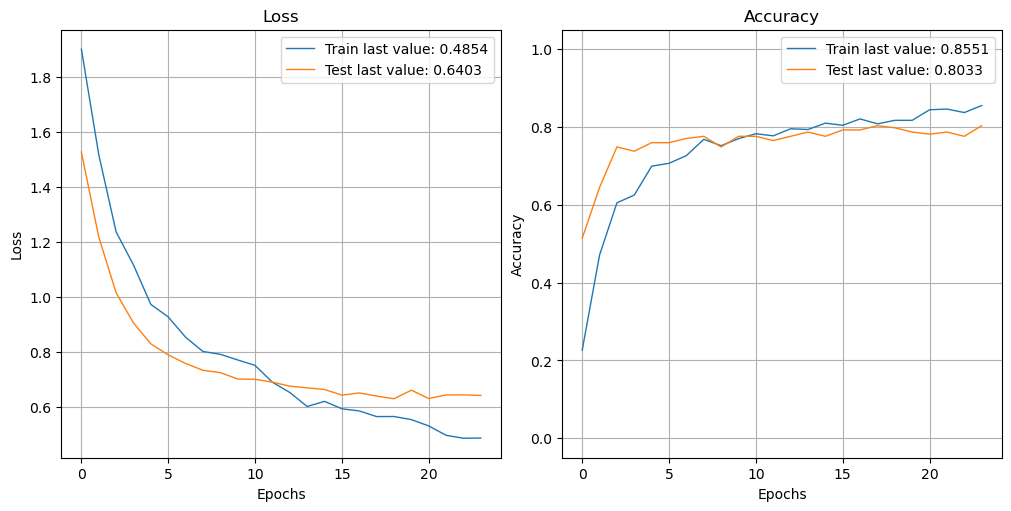

In [63]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

### Conclusion

In [71]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Approche préparation initiale des images,0.823810,0.828571,1.151533,0.780986,00:11:54
1,Approche ImageDatagenerator avec data augmentation,0.757143,0.757143,0.802688,1.108676,00:15:00
2,Approche nouvelle par Dataset sans data augmentation,0.797814,0.787302,0.982012,1.254702,00:18:03
3,Approche nouvelle par Dataset avec data augmentation intégrée au modèle,0.797814,0.765079,0.628237,0.680146,00:29:56


- Approche 1 :  meilleur score de précision mais il y a un surapprentissage
- Approche 2 : moins bon score de précision et encore du surapprentissage

Les 2 premières approches sont dépréciées donc on ne les choisira pas.

- Approche 3 : surapprentissage mais les scores de précisions sont très bons
- Approche 4 : bons scores de précisions et beaucoup moins de surapprentissage pour ce modèle mais le temps nécessaire pour l'entrainement du modèle est plus élevé mais reste raisonnable

le modèle le plus performant pour la problématique métier est l'approche par Dataset avec data augmentation intégrée au modèle.